In [2]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import pytesseract
import unicodedata
import jaconv

# pytesseract.pytesseract.tesseract_cmd = "/usr/local/Cellar/tesseract/4.1.0/bin/tesseract"

hard_code = {'name': [0.07, 1, 1], 'date_of_birth': [0.11, 0.38, 2], 'gender': [0.38, 0.5, 2], 'nationality': [0.6, 0.81, 2], \
    'address': [0.1, 0.71, 4], 'period_of_stay': [0.22, 0.3, 7], 'type_permission': [0.14, 0.55, 9], 'permitted_date': [0.13, 0.36, 10],\
             'expiration_date': [0.17, 0.52, 11]}

def to_bin(path):
    image = cv2.imread(path, 0)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image


def remover(path, low=0, high=255):
    image = cv2.imread(path, 0)
    print(image.mean())
    _, image = cv2.threshold(image, image.mean()/1.4, high, cv2.THRESH_BINARY)
    return image


def showimg(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}", fontproperties='')
    plt.show()

def get_vertical_profile(im):
    v_prof = np.sum((im), axis=1)
    smoothed_prof = smooth(v_prof, 9)
    plt.plot(smoothed_prof)
    plt.show()
    return smoothed_prof

def filter_small_part(img, _rotate):
    # showimg(img)
    x, y, width, height = cv2.boundingRect(img)
    # print(x,y,width,height)
    # print(img.shape)
    img = img[y:y+height, x:x+width]
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(
        img.astype(np.uint8), connectivity=8)
    new_img = np.zeros_like(img)

    # plt.imshow(img)
    # plt.show()

    for i in range(1, ret):
        cc_x = stats[i, cv2.CC_STAT_LEFT]
        cc_y = stats[i, cv2.CC_STAT_TOP]
        cc_width = stats[i, cv2.CC_STAT_WIDTH]
        cc_height = stats[i, cv2.CC_STAT_HEIGHT]

        if cc_width >= 0.2*width or cc_height >= 0.2*height:
            # if cc_width >= 0.1*width or cc_height >= 0.1*height:
            new_img[labels == i] = 1

        if cc_y <= height*0.2:
            print('SHAPE: ', width, height)
            print('CC: ', cc_width, cc_height)
            if cc_width >= 0.3*width and 0.05*height <= cc_height <= 0.2*height:
                _rotate = False
    return (new_img, _rotate)


def padding(sub_img):
    padding = np.ones((50, sub_img.shape[1]))
    tmp_img = np.concatenate((padding*255, sub_img, padding*255), axis=0)
    return tmp_img

def card_number(rotated):
    img_number = rotated[:rotated.shape[0]//3, int(rotated.shape[1]*3.5//5):]
    # showimg(img_number)

    # denoise some super big cc and super small cc
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(img_number, connectivity=8)
    for i in range(1, ret):
        if stats[i, cv2.CC_STAT_WIDTH] > 0.7*img_number.shape[1] or \
            stats[i, cv2.CC_STAT_WIDTH] < 15 and stats[i, cv2.CC_STAT_HEIGHT] < 15 or \
                stats[i, cv2.CC_STAT_TOP] < img_number.shape[0]*0.1:
            img_number[labels == i] = 0

    # horizontal projection 
    # showimg(img_number)
    hist = cv2.reduce(img_number, 1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 0
    H, W = img_number.shape[:2]
    uppers = [y for y in range(H-1) if hist[y] <= th and hist[y+1] > th]
    lowers = [y for y in range(H-1) if hist[y] > th and hist[y+1] <= th]
    print(uppers, lowers)
    if uppers and lowers:
        uppers = uppers[0]
        lowers = lowers[0]
    else:
        print("Can't extract number ID")
        return ""
    img_number = 255 - img_number[uppers:lowers, :]
    # showimg(img_number)
    img_number = padding(img_number)
    showimg(img_number)
    result = pytesseract.image_to_string(img_number, lang='eng').split(' ')
    print(result)
    for r in result:
        if len(r) >= 12:
            return(r[-12:])
            #print(r[-12:])
    return ""


    # print(uppers, lowers)
    # print(len(uppers), len(lowers))
    # rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
    # for y in uppers:
    #     cv2.line(rotated, (0, y), (W, y), (255, 0, 0), 1)

    # for y in lowers:
    #     cv2.line(rotated, (0, y), (W, y), (0, 255, 0), 1)
    # showimg(rotated)

def denoise(rotated):
    # remove noise
    img_ = rotated.copy()
    img_debug = 255-img_
    # showimg(255-img_)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(img_, connectivity=8)
    max_cc = max([stats[i, cv2.CC_STAT_HEIGHT] for i in range(1, ret)])
    for i in range(1, ret):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #im2 = cv2.rectangle(img_debug, (x, y), (x+w, y+h), (0, 255, 0), 1)
        if stats[i, cv2.CC_STAT_WIDTH] < 15 and stats[i, cv2.CC_STAT_HEIGHT] < 15 \
            or stats[i, cv2.CC_STAT_WIDTH]/stats[i, cv2.CC_STAT_HEIGHT] > 10 or \
                stats[i, cv2.CC_STAT_TOP] > img_.shape[0]*0.9:
            img_[labels == i] = 0
    # showimg(im2)
    # showimg(255-img_)
    return img_

def another_try(path):
    info = {}
    #IMG_0872
    import matplotlib.image as mpimg
    showimg(to_bin(path))
    image = mpimg.imread(path)
    # img = cv2.imread("/Users/binhna/Downloads/cmnd2.jpg")
    showimg(image)
    img = remover(path, 85, 255)
    img = 255 - img
    showimg(img)
    
    
    pts = cv2.findNonZero(img)
    ret = cv2.minAreaRect(pts)
    (cx, cy), (w, h), ang = ret
    if w < h:
        w, h = h, w
        ang += 90
    print(cx, cy, w, h, ang)

    tmp = img.copy()
    tmp = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(tmp, (int(cx), int(cy)), (int(cx+w), int(cy+h)), (0, 255, 0), 3)
    showimg(tmp)


    M = cv2.getRotationMatrix2D((cx, cy), ang, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    showimg(rotated)

    # Resize to height = 1650 x width
    h, w = rotated.shape[:2]
    min_edge = 0 if h/w < 1 else 1
    factor = 1
    if rotated.shape[min_edge] < 1650:
        factor = 1650/rotated.shape[min_edge]
    rotated = cv2.resize(rotated, None, fx=factor, fy=factor,
                     interpolation=cv2.INTER_CUBIC)
    # print(img.shape)

    showimg(rotated)
    
    info['card_number'] = card_number(rotated)
    print(f"card number: {info['card_number']}")

    ## (5) find and draw the upper and lower boundary of each lines
    # [:, rotated.shape[1]//5:int(rotated.shape[1]*2/5)]
    ## this tmp_img is for getting the lines of text
    tmp_img = rotated[:, rotated.shape[1]//5:int(rotated.shape[1]*3/5)]
    tmp_img = denoise(tmp_img)
    ## horizontal projection
    hist = cv2.reduce(tmp_img, 1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 0
    H, W = tmp_img.shape[:2]
    uppers = [y for y in range(H-1) if hist[y] <= th and hist[y+1] > th]
    lowers = [y for y in range(H-1) if hist[y] > th and hist[y+1] <= th]
    print(uppers, lowers)
    
    ## make sure uppers and lowers have the same len
    len_min = min(len(uppers), len(lowers))
    uppers = uppers[:len_min]
    lowers = lowers[:len_min]

    img = 255 - rotated.copy()
    rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
    for y in uppers:
        cv2.line(rotated, (0, y), (rotated.shape[1], y), (255, 0, 0), 1)

    for y in lowers:
        cv2.line(rotated, (0, y), (rotated.shape[1], y), (0, 255, 0), 1)
    
    showimg(rotated)

    h, w = img.shape[:2]
    for key, value in hard_code.items():
        line = value[-1]
        if line >= len(uppers):
            break
        start = int(value[0]*w)
        end = int(value[1]*w)
        sub_img = img[uppers[line]:lowers[line], start:end]
        sub_img = padding(sub_img)
        lang = 'jpn' if line != 1 else 'eng'
        result = pytesseract.image_to_string(sub_img, lang=lang)
        result = unicodedata.normalize("NFKC", result)
        result = jaconv.normalize(result, 'NFKC')
        info[key] = result
    
    #info['gender'] = '男' if 'M' in info['gender'] else '女'
    for key, value in info.items():
        print(f"{key}: {value}")
    # for i in range(len(uppers)):
    #     sub_img = img[uppers[i]:lowers[i],:]
    #     sub_img = denoise(sub_img.copy())
    #     sub_img = 255 - sub_img
    #     padding = np.ones((50, sub_img.shape[1]))
    #     tmp_img = np.concatenate(
    #         (padding*255, sub_img, padding*255), axis=0)
    #     # showimg(tmp_img)
    #     lang = 'jpn_best' if i != 1 else 'eng'
    #     result = pytesseract.image_to_string(tmp_img, lang=lang)
    #     result = result.replace("ll", 'H').replace(
    #         "²", "2").replace("º", "o").replace("†", "1")
    #     print(f"{result}")
    #     if i == 3:
    #         print(f"ID Number: {pytesseract.image_to_string(255-sub_img, lang='vie')}")
    #     elif i == 4:
    #         print(f"Name: {pytesseract.image_to_string(255-sub_img, lang='vie')}")
    #     elif i == 5:
    #         print(
    #             f"Date of birth: {pytesseract.image_to_string(255-sub_img, lang='vie')}")

    # showimg(255-rotated)
    


    #showimg(255-img_)

# first_try()
#another_try("images/zairyuu1.jpg")


ModuleNotFoundError: No module named 'pytesseract'

In [25]:
import json
with open('storage/vie_names.json') as f:
    data = json.load(f)

In [26]:
names = []
for i in data:
    names.extend(i['full_name'].split(" "))

In [23]:
names = list(set(names))

In [14]:
import unidecode
names = [unidecode.unidecode(name) for name in names]

In [19]:
names = [name.upper() for name in names]

In [27]:
names

['Nguyễn',
 'Thị',
 'Như',
 'Quỳnh',
 'Lê',
 'Hoàng',
 'Quân',
 'Đinh',
 'Văn',
 'Phượng',
 'Nguyễn',
 'Echam',
 'Samuel',
 'Nguyễn',
 'Xuân',
 'Sang',
 'Lê',
 'Phú',
 'Quý',
 'Lý',
 'Quốc',
 'Quyền',
 'Bùi',
 'Minh',
 'Quân',
 'Nguyễn',
 'Ngọc',
 'Sơn',
 'Bùi',
 'Duy',
 'Qúy',
 'Võ',
 'Hoàng',
 'Phương',
 'Trần',
 'Minh',
 'Phương',
 'Phan',
 'Duy',
 'Quốc',
 'Nguyễn',
 'Vũ',
 'Ngọc',
 'Quyên',
 'Trương',
 'Trọng',
 'Quân',
 'Phạm',
 'Minh',
 'Quân',
 'Võ',
 'Thanh',
 'Sanh',
 'Nguyễn',
 'Minh',
 'Phương',
 'Nguyễn',
 'Viết',
 'Sơn',
 'Vũ',
 'Hoàng',
 'Hải',
 'Sơn',
 'Nguyễn',
 'Hải',
 'Sơn',
 'Nguyễn',
 'Vũ',
 'Trường',
 'Sơn',
 'Trần',
 'Minh',
 'Sang',
 'Nguyễn',
 'Trung',
 'Sơn',
 'Lê',
 'Quang',
 'Vũ',
 'Thị',
 'Phương',
 'Nguyễn',
 'Văn',
 'Sơn',
 'Lê',
 'Anh',
 'Sơn',
 'Võ',
 'Tiến',
 'Sĩ',
 'Phan',
 'Đức',
 'Sơn',
 'Trần',
 'Thế',
 'Sơn',
 'Vũ',
 'Hồng',
 'Tâm',
 'Nguyễn',
 'Minh',
 'Tân',
 'Lê',
 'Hà',
 'Xuân',
 'Thái',
 'Nguyễn',
 'Ngọc',
 'Phương',
 'Bùi',
 'Anh',
 'Tài',
 

In [9]:
def padding(sub_img):
    padd = np.ones((50, sub_img.shape[1]))
    tmp_img = np.concatenate((padd*255, sub_img, padd*255), axis=0)
    return tmp_img


In [30]:
def extend(sub_img):
    padd = np.ones((sub_img.shape[0], 300))
    tmp_img = np.concatenate((sub_img, padd*255), axis=1)
    return tmp_img

In [8]:
import re
import unicodedata
import jaconv
def regex_date(s: str):
    d = re.compile('(\d{4})[^\d]*(\d{2})[^\d]*(\d{2})', re.IGNORECASE)
    result = re.findall(d, s)
    result = result[0] if result else result
    if len(result) == 3:
        out = f"{result[0]} 年 {result[1]} 月 {result[2]} 日"
    else:
        return s
    return out

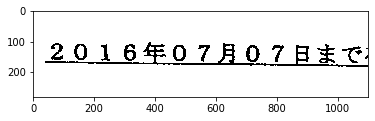

'2 0 1 6 年 0 7 月 0 7 日 ま で :'

In [29]:
import pytesseract
#showimg(remover('/Users/binhna/Desktop/o25_cv2.png'))
img = cv2.imread('/Users/binhna/Desktop/expiration_date2.png', 0)
img = padding(img)
#img = extend(img)
img = img[:, :1100]
showimg(img)
#config = ('-l jpn_best --oem 2 --psm 3')
result = pytesseract.image_to_string(img, lang='jpn_best')
result = unicodedata.normalize("NFKC", result)
result = jaconv.normalize(result, 'NFKC')
regex_date(result)

In [21]:
s = """07

5年(2024年05

D

Y

Y"""

In [25]:
s = s.strip()
print(s)

07

5年(2024年05

D

Y

Y


In [ ]:
上 陸 許 可
在 留 資 格 変 更 許 可
在 留 期 間 更 新 許 可
在 留 資 格 取 得 許 可
永 住 許 可
在 留 特 別 許 可